<b> Load packages

In [71]:
library(glmnet)
library(MASS)
library(readxl)
library(plotmo)
library(MLmetrics)
library(lavaan)
library(ggplot2)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


<b> Input the data

In [2]:
data <- read_excel("Math Department Diet Mood total .xlsx")

Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
"Expecting date in A2588 / R2588C1: got '2019/10/06 10:49:36 PM AST'"Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
"Expecting date in A2589 / R2589C1: got '2019/10/06 10:50:51 PM AST'"Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
"Expecting date in A2590 / R2590C1: got '2019/10/06 11:03:45 PM AST'"Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
"Expecting date in A2591 / R2591C1: got '2019/10/06 11:26:50 PM AST'"Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
"Expecting date in A2592 / R2592C1: got '2019/10/06 4:23:19 PM AST'"Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
"Expecting date in A2593 / R2593C1: got '2019/10/06 4:25:01 PM AST'"Warning message in read_fun(path = enc2native(normalizePath(path))

<b> Check data and variables

In [3]:
dim(data)

[1] 2636   27

In [4]:
for (i in 1:length(data)) {
  data[,i] = as.factor(as.matrix(data[,i]))
  print(unique(data[,i]))
}

# A tibble: 2,533 x 1
   Timestamp          
   <fct>              
 1 2014-03-11 06:39:38
 2 2014-03-11 06:42:58
 3 2014-03-11 07:04:07
 4 2014-03-11 07:14:35
 5 2014-03-11 07:17:27
 6 2014-03-11 07:20:44
 7 2014-03-11 07:33:16
 8 2014-03-11 07:41:05
 9 2014-03-11 07:45:39
10 2014-03-11 07:46:18
# ... with 2,523 more rows
# A tibble: 4 x 1
  `1. What is your gender?`
  <fct>                    
1 Female                   
2 Male                     
3 <NA>                     
4 Other                    
# A tibble: 10 x 1
   `2. What is your age?`
   <fct>                 
 1 18-29                 
 2 30-39                 
 3 40-49                 
 4 50 and above          
 5 40-50                 
 6 50-60                 
 7 Over 70               
 8 18-25                 
 9 30-40                 
10 25-29                 
# A tibble: 10 x 1
   `3. In which region you are living now?`
   <fct>                                   
 1 Asia                                    
 2 Nort

<b> Rename the data

In [5]:
names(data) = c("timestamp","gender","age","region","education","diet",
                "exercise","breakfast","whole_grain","dairy_product","coffee",
                "fruits","flaxseed/nuts","rice/pasta","meat","vegetables","beans"
                ,"fish","fast_food","multivitamin","fish_oil",
                "nervous","hopeless","restless","depressed","effort","worthless")
names(data)

[1] "timestamp"     "gender"        "age"           "region"       
 [5] "education"     "diet"          "exercise"      "breakfast"    
 [9] "whole_grain"   "dairy_product" "coffee"        "fruits"       
[13] "flaxseed/nuts" "rice/pasta"    "meat"          "vegetables"   
[17] "beans"         "fish"          "fast_food"     "multivitamin" 
[21] "fish_oil"      "nervous"       "hopeless"      "restless"     
[25] "depressed"     "effort"        "worthless"

# 1.1 Cleaning the data 

### Remove observations with N/A

In [6]:
data = na.omit(data)
dim(data)[1]

[1] 2328

### Remove, combine and rename

For **Gender**, there is only one **Other** observation. For better analysis on data, I remove levels with only one observation, the same for other variables.

In [7]:
data = data [-which(data$gender=='Other'),]
dim(data)[1]

[1] 2327

Check **Gender** levels

In [8]:
unique(data[,2])

gender
Female
Male


----

For **Region**:
- There are two **Option 8** observations.
- There are repeated levels such as: **Middle East/North Africa** and **Africa**, **Australia** and **Australia /New Zealand**. I combine those observations into **Africa** and **Australia**.

In [9]:
ureg = unique(data$region)
unique(data[,4])

region
Asia
North America/Central America
Middle East/North Africa
Europe
Africa
Australia<U+00A0>
South America
Option 8
Australia /New Zealand
Australia


In [10]:
data = data [-which(data$region==ureg[8]),]
dim(data)[1]

[1] 2325

In [11]:
#combine into Africa
data$region[which(data$region==ureg[3])] = ureg[5]
#combine into Australia/New Zealand
data$region[which(data$region==ureg[6])] = ureg[9]
data$region[which(data$region==ureg[10])] = ureg[9]
dim(data)[1]

[1] 2325

Check **Region** levels

In [12]:
unique(data[,4])

region
Asia
North America/Central America
Africa
Europe
Australia /New Zealand
South America


----

For **Diet** (type):
- There are repeated levels, such as **Mediterranean Diet** due to the spelling.
- There are **Sophomore** observations, which are levels from other column.
- **Asian diet, Caribbean diet, Korean diet, Vegan diet** each only has one observations.

In [13]:
udt = unique(data$diet)
unique(data[,6])

diet
Mediterranean Diet<U+00A0>
Eastern Diet
Western Diet<U+00A0>
Mediterrenean Diet
Mediterrean Diet
Western Diet
Vegetarian
Vegan
Caribbean diet
Mediterranean Diet


In [14]:
#combine all Mediterranean Diet
data$diet[which(data$diet==udt[1])] = udt[10]
data$diet[which(data$diet==udt[4])] = udt[10]
data$diet[which(data$diet==udt[5])] = udt[10]
#combine all Western Diet
data$diet[which(data$diet==udt[3])] = udt[6]
data$diet[which(data$diet==udt[11])] = udt[6]
#remove Sophomore observations
data = data[-which(data$diet==udt[15]),]
dim(data)[1]
#remove Asian diet, Caribbean diet, Korean diet, Vegan diet
data = data[-which(data$diet==udt[7]),]
data = data[-which(data$diet==udt[8]),]
data = data[-which(data$diet==udt[9]),]
data = data[-which(data$diet==udt[12]),]
data = data[-which(data$diet==udt[13]),]
data = data[-which(data$diet==udt[14]),]
dim(data)[1]

[1] 2323

[1] 2314

Check **Diet** levels

In [15]:
unique(data[,6])

diet
Mediterranean Diet
Eastern Diet
Western Diet


---

For **Breakfast**:

In [16]:
u8 = unique(data$breakfast)
unique(data[,8])

breakfast
4 times
6 or 7 times
1 time
5 times
3 times
2 times
None
Never


In [17]:
data$breakfast[which(data$breakfast==u8[8])] = u8[7]
dim(data)[1]

[1] 2314

Check **Breakfast** levels:

In [18]:
unique(data[,8])

breakfast
4 times
6 or 7 times
1 time
5 times
3 times
2 times
None


---

For **Whole grain**:

In [19]:
u9 = unique(data$whole_grain)
unique(data[,9])

whole_grain
More than 4 times
1 time
2 times<U+00A0>
None
4 times
3 times
2 times


In [20]:
data$whole_grain[which(data$whole_grain==u9[3])] = u9[7]
dim(data)[1]

[1] 2314

Check **Whole grain** levels:

In [21]:
unique(data[,9])

whole_grain
More than 4 times
1 time
2 times
None
4 times
3 times


---

For **Dairy product**:

In [22]:
u10 = unique(data$dairy_product)
unique(data[,10])

dairy_product
More than 4 times
1 time
2 times
3 times
4 times
None
More that 4 times
1 serving


In [23]:
data$dairy_product[which(data$dairy_product==u10[8])] = u10[2]
data$dairy_product[which(data$dairy_product==u10[7])] = u10[1]
dim(data)[1]

[1] 2314

Check **Dairy product** levels:

In [24]:
unique(data[,10])

dairy_product
More than 4 times
1 time
2 times
3 times
4 times
None


---

For **Coffee**:

In [26]:
u11 = unique(data$coffee)
unique(data[,11])

coffee
More than 4 times
3 times
2 times
None
4 times
1 time
Never


In [27]:
data$coffee[which(data$coffee==u11[7])] = u11[4]
dim(data)[1]

[1] 2314

Check **Coffee** levels:

In [28]:
unique(data[,11])

coffee
More than 4 times
3 times
2 times
None
4 times
1 time


---

For **Vegetables**:

In [34]:
u16 = unique(data$vegetables)
unique(data[,16])

vegetables
1 time
2 times
4 times
More than 4 times
3 times
None
1 serving


In [35]:
data$vegetables[which(data$vegetables==u16[7])] = u16[1]
dim(data)[1]

[1] 2314

Check **Vegetables** levels:

In [37]:
unique(data[,16])

vegetables
1 time
2 times
4 times
More than 4 times
3 times
None


---

For **Beans**:

In [39]:
u17 = unique(data$beans)
unique(data[,17])

beans
None
1 time
4 times
2 times<U+00A0>
3 times
More than 4 times
2 times


In [40]:
data$beans[which(data$beans==u17[4])] = u17[7]
dim(data)[1]

[1] 2314

Check **Beans** levels:

In [41]:
unique(data[,17])

beans
None
1 time
4 times
2 times
3 times
More than 4 times


---

For **Fish oil**:

In [46]:
u21 = unique(data$fish_oil)
unique(data[,21])

fish_oil
None
1 time
More than 4 times
2 times
3 times
4 times
1 times


In [47]:
data$fish_oil[which(data$fish_oil==u21[7])] = u21[1]
dim(data)[1]

[1] 2314

Check **Fish oil** levels:

In [48]:
unique(data[,21])

fish_oil
None
1 time
More than 4 times
2 times
3 times
4 times


---

For **Nervous**:

In [50]:
u22 = unique(data$nervous)
unique(data[,22])

nervous
All the time
Some of the time
Most of the time
None of the time
A little of the time
None


In [51]:
data$nervous[which(data$nervous==u22[6])] = u22[4]
dim(data)[1]

[1] 2314

Check **Nervous** levels:

In [52]:
unique(data[,22])

nervous
All the time
Some of the time
Most of the time
None of the time
A little of the time


---

After above cleaning, there are **2314** observations left.

# 1.2 Convert categorical variables into numerical variables

To obtain more information from the data, I convert a categorical variable into a numerical variable if levels of variable indicate clear order.

In [60]:
x=as.data.frame(data[,2:21])
y=as.matrix(data[,22:27])

- For **Education**, I convert it into number 1 to 8, from low education level to high education level according to the order of 'Less than high school','High school','AA, BA, BS','Graduate','Master's Degree','Doctoral Degree','Professional Degree','Professional'.

In [62]:
xm1 = matrix(0,dim(x)[1],1)
for (i in 1:dim(x)[1]) {
  if (x[i,4]=="Less than High School"){
    xm1[i,1]=1
  }
  if (x[i,4]=="High School"){
    xm1[i,1]=2
  }
  if (x[i,4]=="2 or 4 Years of College Degree (AA, BA, BS)"){
    xm1[i,1]=3
  }
  if (x[i,4]=="Graduate"){
    xm1[i,1]=4
  }
  if (x[i,4]=="Master's Degree"){
    xm1[i,1]=5
  }
  if (x[i,4]=="Doctoral Degree"){
    xm1[i,1]=6
  }
  if (x[i,4]=="Professional Degree (MD, JD, PharmD, ...)"){
    xm1[i,1]=7
  }
  if (x[i,4]=="Professional"){
    xm1[i,1]=8
  }
}
x[,4]=xm1


3
5
6
2
7
1
8
4


In [63]:
unique(x$edu)

3
5
6
2
7
1
8
4


- For the frequency of consuming different type of food, I convert 'None' into 0, and 'More than X times' into X +1, frequency between 1 and X to the relative number.

In [64]:
xm=matrix(0,dim(x)[1],dim(x)[2])
for (i in 6:20) {
  for (j in 1:nrow(x)) {
    if (x[j,i]=='None'){
      xm[j,i]=0
    }
    if (x[j,i]=='1 time'){
      xm[j,i]=1
    }
    if ((x[j,i]=='2 times')|(x[j,i]==unique(x[,8])[3])){
      xm[j,i]=2
    }
    if ((x[j,i]=='3 times')|(x[j,i]==unique(x[,12])[2])){
      xm[j,i]=3
    }
    if (x[j,i]=='4 times'){
      xm[j,i]=4
    }
    if ((x[j,i]=='5 times')|(x[j,i]=='More than 4 times')){
      xm[j,i]=5
    }
    if (x[j,i]=='6 or 7 times'){
      xm[j,i]=6
    }
  }
}
x[,6:20]=xm[,6:20]

In [65]:
for (i in 6:20) {
  print(unique(x[,i]))
}

[1] 0 1 2 4 5 3
[1] 4 6 1 5 3 2 0
[1] 5 1 2 0 4 3
[1] 5 1 2 3 4 0
[1] 5 3 2 0 4 1
[1] 3 4 1 2 5 0
[1] 1 3 0 5 2 4
[1] 5 2 4 3 1 0
[1] 5 2 4 3 1 0
[1] 1 2 4 5 3 0
[1] 0 1 4 2 3 5
[1] 1 0 3 2 5 4
[1] 0 1 4 5 2 3
[1] 0 5 2 1 3 4
[1] 0 1 5 2 3 4


- To interpret the mental health status better, I convert 'All the time'... 'None of the time' into 1 to 5, and get a new response called **mental health score** from the average of the original 6 responses.

In [66]:
s=matrix(0,dim(y)[1],dim(y)[2])
for (i in 1:dim(y)[1]) {
  for (j in 1:dim(y)[2]) {
    if (y[i,j]=='None of the time'){
      s[i,j]=5
    }
    if (y[i,j]=='A little of the time'){
      s[i,j]=4
    }
    if (y[i,j]=='Some of the time'){
      s[i,j]=3
    }
    if (y[i,j]=='Most of the time'){
      s[i,j]=2
    }
    if (y[i,j]=='All the time'){
      s[i,j]=1
    }
  }
}
y=rowMeans(s)

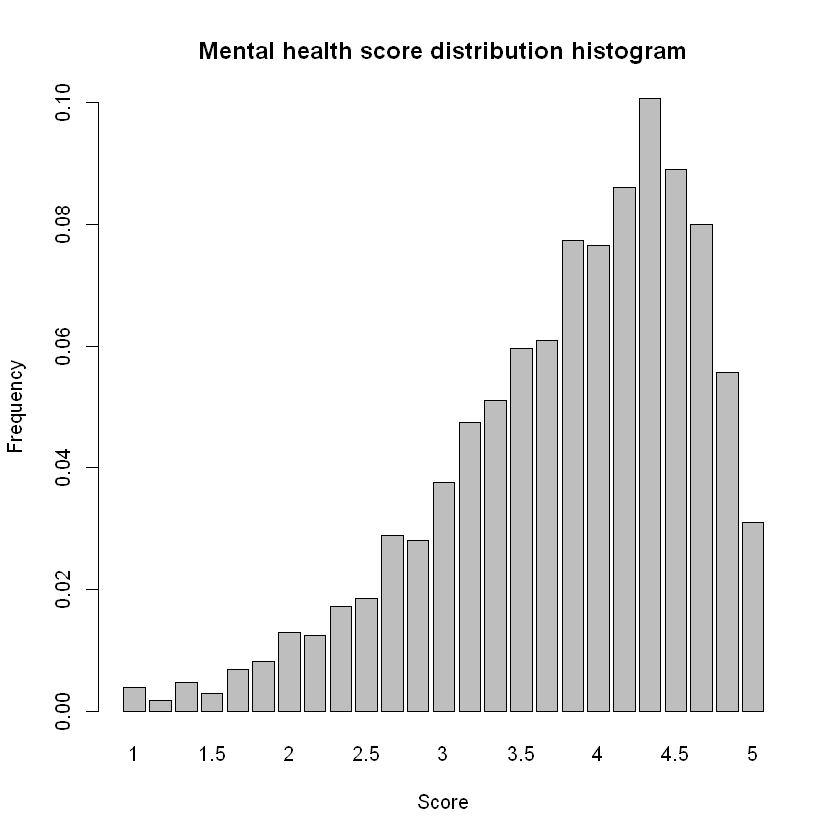

In [68]:
barplot(prop.table(table(y)),main = 'Mental health score distribution histogram',xlab = 'Score', ylab = 'Frequency')

# 1.3 New Dataset Summary

A new data set with **2314** observations, **20** variables and **1** response is obtained.

| **Name of variable** | **Type**    | **Description**                            |
|:---------------------|:------------|:-------------------------------------------|
| y (Mental health score)| Numerical   | Mental health score, from 1 to 5           |
| Gender               | Categorical | Female or Male                             |
| Age                  | Categorical | 18-29, 30-39, 40-49 or 50 and above        |
| Region               | Categorical | Continent participant comes from           |
| Diet                 | Categorical | Different diet type                        |
| Education            | Numerical   | From 1 to 8, indicating education level    |
| Exercise             | Numerical   | Frequency of exercise per week             |
| Breakfast            | Numerical   | Frequency of breakfast per week            |
| Whole grain          | Numerical   | Frequency of eating whole grain per week   |
| Dairy product        | Numerical   | Frequency of eating dairy product per week |
| Coffee               | Numerical   | Frequency of drinking coffee per week      |
| Fruit                | Numerical   | Frequency of eating fruit per week         |
| Flaxseed/nuts        | Numerical   | Frequency of eating flaxseed/nuts per week |
| Rice/pasta           | Numerical   | Frequency of eating rice/pasta per week    |
| Meat                 | Numerical   | Frequency of eating meat per week          |
| Vegetables           | Numerical   | Frequency of eating vegetables per week    |
| Beans                | Numerical   | Frequency of eating beans per week         |
| Fish                 | Numerical   | Frequency of eating fish per week          |
| Fast food            | Numerical   | Frequency of eating fast food per week     |
| Multivitamin         | Numerical   | Frequency of eating multivitamin per week  |
| Fish oil             | Numerical   | Frequency of eating fish oil per week      |


# 2.1 Visualization

One direct way is to visualize the average mental health score for each level/value of each variable, and find out any significance or trend.

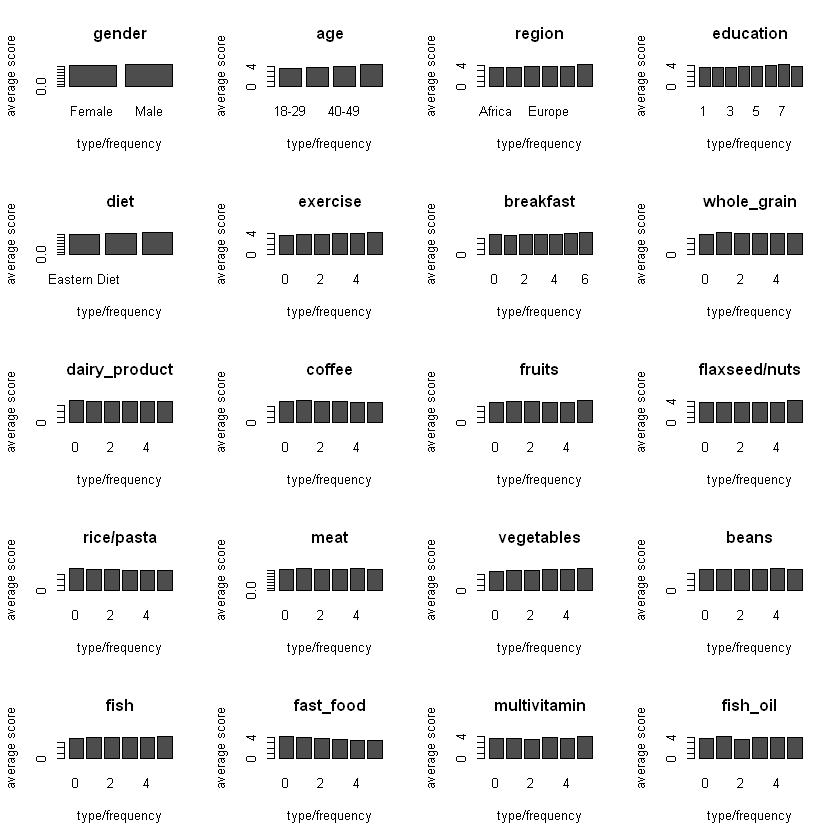

In [70]:
par(mfrow=c(5,4))
for (i in 1:dim(x)[2]) {
  what=matrix(0,1,length(unique(x[,i])))
  colnames(what)=sort(unique(x[,i]))
  for (j in 1:length(unique(x[,i]))) {
    what[1,j]=mean(y[x[,i]==sort(unique(x[,i]))[j]])
  }
  barplot(what,main=as.character(colnames(x)[i]),xlab='type/frequency',ylab = 'average score')
}
par(mfrow=c(1,1))